## Python code to script the Analog Discovery 3

#### Post installation all the sample codes are available in the `C:\Program Files (x86)\Digilent\WaveFormsSDK\samples\py` Folder
#### [Click here for Device Datasheet](https://mm.digikey.com/Volume0/opasdata/d220001/medias/docus/7152/Digilent-410-415-DB-1_DE%20%281%29.pdf)
#### [Click here for class handbook](https://github.com/ShivamBhadani/AnalogDiscovery/blob/main/ad3_v1_1.pdf)
#### [click here to Get Started with WaveForms SDK](https://digilent.com/reference/test-and-measurement/guides/waveforms-sdk-getting-started)
### Imports

In [1]:
import ctypes                     # import the C compatible data types
import time
from sys import platform, path    # this is needed to check the OS type and get the PATH
from os import sep                # OS specific file path separators
import matplotlib.pyplot as plt
import numpy
import time
import datetime
import wave
import os

### Config

In [2]:
dwf = ctypes.cdll.dwf
constants_path = "C:" + sep + "Program Files (x86)" + sep + "Digilent" + sep + "WaveFormsSDK" + sep + "samples" + sep + "py"
path.append(constants_path)
import dwfconstants as constants

### Opening a device

In [3]:
filter_flags = ctypes.c_int(constants.enumfilterType.value | constants.enumfilterDemo.value)
# Enumerate devices
device_count = ctypes.c_int()
dwf.FDwfEnum(filter_flags, ctypes.byref(device_count))
print(f"Number of devices found: {device_count.value}")
# Retrieve device name (optional)
name_buf = ctypes.create_string_buffer(64)
dwf.FDwfEnumDeviceName(ctypes.c_int(0), name_buf)
print(f"Detected device: {name_buf.value.decode()}")
hdwf = ctypes.c_int()
dwf.FDwfDeviceOpen(ctypes.c_int(0), ctypes.byref(hdwf))
if hdwf.value == 0:
    raise RuntimeError("Failed to open demo device.")
print("Demo device opened successfully!")

Number of devices found: 15
Detected device: Analog Discovery 3
Demo device opened successfully!


### Using the Oscilloscope

Starting oscilloscope
Acquisition done
DC: 0.006885413080453873V


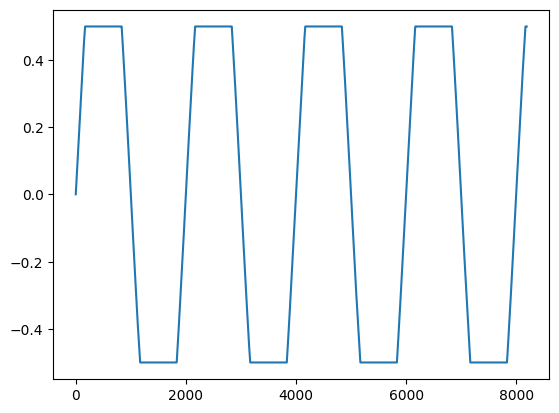

In [111]:
sampling_frequency = 20e06
buffer_size = 8192
amplitude_range = 1
offset =0
sts = ctypes.c_byte()
rgdSamples = (ctypes.c_double*ctypes.c_int(buffer_size).value)()

# check for opened device
dwf.FDwfEnum(filter_flags, ctypes.byref(device_count))
assert device_count.value>0, "Please open a device before using the oscilloscope"

# enable all channels
dwf.FDwfAnalogInChannelEnableSet(hdwf, ctypes.c_int(0), ctypes.c_bool(True))
 
# set offset voltage (in Volts)
dwf.FDwfAnalogInChannelOffsetSet(hdwf, ctypes.c_int(0), ctypes.c_double(offset))
 
# set range (maximum signal amplitude in Volts)
dwf.FDwfAnalogInChannelRangeSet(hdwf, ctypes.c_int(0), ctypes.c_double(amplitude_range))
 
# set the buffer size (data point in a recording)
dwf.FDwfAnalogInBufferSizeSet(hdwf, ctypes.c_int(buffer_size))
 
# set the acquisition frequency (in Hz)
dwf.FDwfAnalogInFrequencySet(hdwf,ctypes.c_double(sampling_frequency))
 
# disable averaging (for more info check the documentation)
dwf.FDwfAnalogInChannelFilterSet(hdwf, ctypes.c_int(-1), constants.filterDecimate)

time.sleep(2)

print("Starting oscilloscope")
dwf.FDwfAnalogInConfigure(hdwf, ctypes.c_int(1), ctypes.c_int(1))

while True:
    dwf.FDwfAnalogInStatus(hdwf, ctypes.c_int(1), ctypes.byref(sts))
    if sts.value == constants.DwfStateDone.value :
        break
    time.sleep(0.1)
print("Acquisition done")
dwf.FDwfAnalogInStatusData(hdwf, 0, rgdSamples, ctypes.c_int(buffer_size).value) # get channel 1 data

#plot window
dc = sum(rgdSamples)/len(rgdSamples)
print("DC: "+str(dc)+"V")

plt.plot(numpy.fromiter(rgdSamples, dtype = numpy.float64))
plt.show()

### Waveform Generation

In [110]:
wavegen_frequency = 1e4
wavegen_dc = 0.0
wavegen_amplitude = 1.0

# check for device connection
dwf.FDwfEnum(filter_flags, ctypes.byref(device_count))
assert device_count.value>0, "Please open a device before using the oscilloscope"

# Enable the waveform generator output (channel 0, node 0)
# - hdwf: device handle
# - 0: channel index
# - 0: node (main signal path, typically "Carrier")
# - 1: enable (True)
dwf.FDwfAnalogOutNodeEnableSet(hdwf, 0, 0, 1)

# Set the waveform type to sine wave
# - funcSine: predefined constant for sine waveform
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, 0, 0, constants.funcSine)

# Set the frequency of the output sine wave to 10,000 Hz (10 kHz)
dwf.FDwfAnalogOutNodeFrequencySet(hdwf, 0, 0, ctypes.c_double(wavegen_frequency))

# Set the DC offset of the waveform to 0 V (centers it around 0)
dwf.FDwfAnalogOutNodeOffsetSet(hdwf, 0, 0, ctypes.c_double(wavegen_dc))

# Set the peak amplitude of the sine wave to 1 V
# (i.e., the wave will swing from -1V to +1V)
dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, 0, 0, ctypes.c_double(wavegen_amplitude))

# Start the output signal
# - 0: channel index
# - 1: start (True)
dwf.FDwfAnalogOutConfigure(hdwf, 0, 1)

1

### AnalogIn Record mode

In [ ]:
#declare ctype variables
vOffset = ctypes.c_double(1.41)
vAmplitude = ctypes.c_double(1.41)
hzSignal = ctypes.c_double(80)
hzAcq = ctypes.c_double(80000)
nSamples = 800000
sts = ctypes.c_byte()
cAvailable = ctypes.c_int16()
cAvailable.value=0
cLost = ctypes.c_int()
cCorrupted = ctypes.c_int()
fLost = 0
fCorrupted = 0

dwf.FDwfDeviceAutoConfigureSet(hdwf, ctypes.c_int(0)) # 0 = the device will only be configured when FDwf###Configure is called
#set up acquisition
dwf.FDwfAnalogInChannelEnableSet(hdwf, ctypes.c_int(0), ctypes.c_int(1))
dwf.FDwfAnalogInChannelRangeSet(hdwf, ctypes.c_int(0), ctypes.c_double(2.0*vAmplitude.value))
dwf.FDwfAnalogInChannelOffsetSet(hdwf, ctypes.c_int(0), vOffset)
dwf.FDwfAnalogInAcquisitionModeSet(hdwf, constants.acqmodeRecord)
dwf.FDwfAnalogInFrequencySet(hdwf, hzAcq)
dwf.FDwfAnalogInRecordLengthSet(hdwf, ctypes.c_double(-1)) # -1 infinite record length
dwf.FDwfAnalogInConfigure(hdwf, ctypes.c_int(1), ctypes.c_int(0))

#wait at least 2 seconds for the offset to stabilize
time.sleep(2)

print("Starting oscilloscope")
dwf.FDwfAnalogInConfigure(hdwf, ctypes.c_int(0), ctypes.c_int(1))

cSamples = 0

#open WAV file
starttime = datetime.datetime.now();
startfilename = "AD3_" + "{:04d}".format(starttime.year) + "{:02d}".format(starttime.month) + "{:02d}".format(starttime.day) + "_" + "{:02d}".format(starttime.hour) + "{:02d}".format(starttime.minute) + "{:02d}".format(starttime.second) + ".wav";
print("Writing WAV file '" + startfilename + "'");
waveWrite = wave.open(startfilename, "wb");
waveWrite.setnchannels(1);				# 1 channels 
waveWrite.setsampwidth(2);				# 16 bit / sample
waveWrite.setframerate(hzAcq.value);
waveWrite.setcomptype("NONE","No compression");

try:
    while cSamples < nSamples:
        dwf.FDwfAnalogInStatus(hdwf, ctypes.c_int(1), ctypes.byref(sts))
        if cSamples == 0 and sts.value in {
        constants.DwfStateConfig.value,
        constants.DwfStatePrefill.value,
        constants.DwfStateArmed.value}:
            # Acquisition not yet started.
            continue

        dwf.FDwfAnalogInStatusRecord(hdwf, ctypes.byref(cAvailable), ctypes.byref(cLost), ctypes.byref(cCorrupted)) 
        cSamples += cLost.value

        if cLost.value :
            fLost = 1
        if cCorrupted.value :
            fCorrupted = 1

        if cAvailable.value==0 :
            continue
        numsamples=min(cAvailable.value,nSamples-cSamples)
        print(numsamples)
        if(numsamples<=0):
            break
        rgSamples = (ctypes.c_int16*numsamples)()

        dwf.FDwfAnalogInStatusData16(hdwf, ctypes.c_int(0), rgSamples, ctypes.c_int(0), cAvailable) # get channel 1 data chunk
        cSamples += cAvailable.value
        waveWrite.writeframes(bytes(rgSamples))
        
except KeyboardInterrupt:
    pass	

endtime = datetime.datetime.now();
dwf.FDwfAnalogOutReset(hdwf, ctypes.c_int(0))

print(" done")
if fLost:
    print("Samples were lost! Reduce frequency")
if fCorrupted:
    print("Samples could be corrupted! Reduce frequency")

waveWrite.close();

endfilename = "AD3_" + "{:04d}".format(starttime.year) + "{:02d}".format(starttime.month) + "{:02d}".format(starttime.day) + "_" + "{:02d}".format(starttime.hour) + "{:02d}".format(starttime.minute) + "{:02d}".format(starttime.second) + "-" + "{:02d}".format(endtime.hour) + "{:02d}".format(endtime.minute) + "{:02d}".format(endtime.second) + ".wav";
print("Renaming file from '" + startfilename + "' to '" + endfilename + "'");
os.rename(startfilename, endfilename);

print(" done")

In [ ]:
"""
   DWF Python Example
   Author:  Digilent, Inc.
   Revision:  2018-07-19

   Requires:                       
       Python 2.7, 3
   Desciption:
   - generates sine on AWG1
   - records data on Scope 1
   - writes data to 16 bit WAV file
"""

from ctypes import *
from dwfconstants import *
import math
import time
import matplotlib.pyplot as plt
import sys
import numpy
import wave
import datetime
import os
import array

if sys.platform.startswith("win"):
    dwf = cdll.dwf
elif sys.platform.startswith("darwin"):
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
else:
    dwf = cdll.LoadLibrary("libdwf.so")

#declare ctype variables
hdwf = c_int()
sts = c_byte()
vOffset = c_double(2)
vAmplitude = c_double(2)
hzSignal = c_double(800)
hzAcq = c_double(80000)
nSamples = 800000
cAvailable = c_int()
cLost = c_int()
cCorrupted = c_int()
fLost = 0
fCorrupted = 0

#print(DWF version
version = create_string_buffer(16)
dwf.FDwfGetVersion(version)
print("DWF Version: "+str(version.value))

#open device
print("Opening first device")
dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))

if hdwf.value == hdwfNone.value:
    szerr = create_string_buffer(512)
    dwf.FDwfGetLastErrorMsg(szerr)
    print(str(szerr.value))
    print("failed to open device")
    quit()

dwf.FDwfDeviceAutoConfigureSet(hdwf, c_int(0)) # 0 = the device will only be configured when FDwf###Configure is called

print("Generating sine wave...")
dwf.FDwfAnalogOutNodeEnableSet(hdwf, c_int(0), AnalogOutNodeCarrier, c_int(1))
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, c_int(0), AnalogOutNodeCarrier, funcSine)
dwf.FDwfAnalogOutNodeFrequencySet(hdwf, c_int(0), AnalogOutNodeCarrier, hzSignal)
dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, c_int(0), AnalogOutNodeCarrier, vAmplitude)
dwf.FDwfAnalogOutNodeOffsetSet(hdwf, c_int(0), AnalogOutNodeCarrier, vOffset)
dwf.FDwfAnalogOutConfigure(hdwf, c_int(0), c_int(1))

#set up acquisition
dwf.FDwfAnalogInChannelEnableSet(hdwf, c_int(0), c_int(1))
dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(0), c_double(2.0*vAmplitude.value))
dwf.FDwfAnalogInChannelOffsetSet(hdwf, c_int(0), vOffset)
dwf.FDwfAnalogInAcquisitionModeSet(hdwf, acqmodeRecord)
dwf.FDwfAnalogInFrequencySet(hdwf, hzAcq)
dwf.FDwfAnalogInRecordLengthSet(hdwf, c_double(-1)) # -1 infinite record length
dwf.FDwfAnalogInConfigure(hdwf, c_int(1), c_int(0))

#wait at least 2 seconds for the offset to stabilize
time.sleep(2)

print("Starting oscilloscope")
dwf.FDwfAnalogInConfigure(hdwf, c_int(0), c_int(1))

cSamples = 0

print("Generating "+str(hzSignal.value)+"Hz, recording "+str(hzAcq.value)+"Hz for "+str(nSamples/hzAcq.value)+"s, press Ctrl+C to stop...");
#get the proper file name

#open WAV file
starttime = datetime.datetime.now();
startfilename = "AD2_" + "{:04d}".format(starttime.year) + "{:02d}".format(starttime.month) + "{:02d}".format(starttime.day) + "_" + "{:02d}".format(starttime.hour) + "{:02d}".format(starttime.minute) + "{:02d}".format(starttime.second) + ".wav";
print("Writing WAV file '" + startfilename + "'");
waveWrite = wave.open(startfilename, "wb");
waveWrite.setnchannels(1);				# 1 channels 
waveWrite.setsampwidth(2);				# 16 bit / sample
waveWrite.setframerate(hzAcq.value);
waveWrite.setcomptype("NONE","No compression");

try:
    while cSamples < nSamples:
        dwf.FDwfAnalogInStatus(hdwf, c_int(1), byref(sts))
        if cSamples == 0 and (sts == DwfStateConfig or sts == DwfStatePrefill or sts == DwfStateArmed) :
            # Acquisition not yet started.
            continue

        dwf.FDwfAnalogInStatusRecord(hdwf, byref(cAvailable), byref(cLost), byref(cCorrupted))
        
        cSamples += cLost.value

        if cLost.value :
            fLost = 1
        if cCorrupted.value :
            fCorrupted = 1

        if cAvailable.value==0 :
            continue

        if cSamples+cAvailable.value > nSamples :
            cAvailable = c_int(nSamples-cSamples)
        
        rgSamples = (c_int16*cAvailable.value)()

        dwf.FDwfAnalogInStatusData16(hdwf, c_int(0), rgSamples, c_int(0), cAvailable) # get channel 1 data chunk
        cSamples += cAvailable.value
        waveWrite.writeframes(rgSamples)
        
except KeyboardInterrupt:
    pass	

endtime = datetime.datetime.now();
dwf.FDwfAnalogOutReset(hdwf, c_int(0))
dwf.FDwfDeviceCloseAll()

print(" done")
if fLost:
    print("Samples were lost! Reduce frequency")
if fCorrupted:
    print("Samples could be corrupted! Reduce frequency")

waveWrite.close();

endfilename = "AD2_" + "{:04d}".format(starttime.year) + "{:02d}".format(starttime.month) + "{:02d}".format(starttime.day) + "_" + "{:02d}".format(starttime.hour) + "{:02d}".format(starttime.minute) + "{:02d}".format(starttime.second) + "-" + "{:02d}".format(endtime.hour) + "{:02d}".format(endtime.minute) + "{:02d}".format(endtime.second) + ".wav";
print("Renaming file from '" + startfilename + "' to '" + endfilename + "'");
os.rename(startfilename, endfilename);

print(" done")



In [ ]:
print("hi")

hi
